<a href="https://colab.research.google.com/github/kash2023k/Pytorch-Project1/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Identifying 0-9 hand written numbers**

In [4]:
# Importing all necessary library for CNN
from keras.models import Sequential
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from keras.layers import Dense, Conv2D, Flatten

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline



In [5]:
# Convert MNIST image files into Tensor of 4 dimensions (# of images , height , width , color channels)

transform = transforms.ToTensor()

In [6]:
# Train Data

train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 455kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


In [7]:
# Test Data

test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
# Lets create a batch size of images .. 10

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False) # We dont want to Shuffle

In [11]:
# Define CNN Model
# Describe CNN layer - 2 layers

conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)


In [12]:
# Lets grab one MNIST Record/image

for i , (X_train, y_train) in enumerate(train_data):
    break


In [13]:
X_train.shape

torch.Size([1, 28, 28])

In [14]:
x = X_train.view(1,1,28,28) # You can use reshape also


In [15]:
# Perform out first convolution

x = F.relu(conv1(x)) #Rectified Linear Unit for our activation function

In [16]:
x.shape # 1 - Single Image , 6- filters , but dimension has reduced from 28x28 to 26x26 because the convolution got rid of the extra padding

torch.Size([1, 6, 26, 26])

In [17]:
# Pass through the pooling layer

x = F.max_pool2d(x, 2, 2) # Kernel Size of 2 and stride size of 2

In [18]:
x.shape # 26 /2 = 13 thus pooled 26x26 to 13x13

torch.Size([1, 6, 13, 13])

In [19]:
# Lets do our second convolutional layer

x= F.relu(conv2(x))

In [20]:
x.shape # lost two pixel on the outside for padding

torch.Size([1, 16, 11, 11])

In [21]:
# Pooling the 2nd convolutional layer

x = F.max_pool2d(x, 2, 2)

In [22]:
x.shape # 11/2 = 5.5 amd we cant rounup because we have lost the data already which cant be recovered and thus we pool dowm

torch.Size([1, 16, 5, 5])

In [23]:
# Model Class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)

    # implementing fully connected layers
    self.fc1 = nn.Linear(5*5*16, 120) # 5*5*16 from the x shape after pooling and 120 is the number of neurons
    self.fc2 = nn.Linear(120, 84) # 120 neunrons from previous connected layer to 84 neurons (arbitrary) next
    self.fc3 = nn.Linear(84,10) # 84 from previous connected layer to 10 as we have 10 classes of number 0-9

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) #2X2 kernal and a stride of 2

    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    #Re-view to flatten it out

    X = X.view(-1, 5*5*16) # Negative so that we can vary the batch size

    #Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)


In [24]:
# Create an instance of our model
# Creating a seed

torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
# Loss function optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # The smaller rate is longer it will time to take

In [26]:
import time #Just curious how much time it takes

start_time = time.time()

#Create variable to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop for epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  #Training
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #Start our bacth with 1
    y_pred = model(X_train)  # Prediction values from training set
    loss = criterion(y_pred, y_train)  # How far off are we from actual
    predicted = torch.max(y_pred.data, 1)[1] # Add up numbers for correct prediction
    batch_corr = (predicted == y_train).sum() # Sum all correct prediction from this batch. True = 1 and False =0 and we sum those off
    trn_corr += batch_corr # Keep a track as we go along in training

    # Update our parameters

    optimizer.zero_grad() # Reset the gradient
    loss.backward() # Back propagation
    optimizer.step() # Update the parameters

    #Print out some results

    if b%600 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')


  # Append loss and correct

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Testing

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')



current = time.time()
total_time = current - start_time
print("The time taken was : ",total_time/60)

Epoch: 0  Batch: 600  Loss: 0.16236107051372528
Epoch: 0  Batch: 1200  Loss: 0.15510495007038116
Epoch: 0  Batch: 1800  Loss: 0.4651116728782654
Epoch: 0  Batch: 2400  Loss: 0.17726822197437286
Epoch: 0  Batch: 3000  Loss: 0.007429888937622309
Epoch: 0  Batch: 3600  Loss: 0.37731707096099854
Epoch: 0  Batch: 4200  Loss: 0.004938055761158466
Epoch: 0  Batch: 4800  Loss: 0.0015040982980281115
Epoch: 0  Batch: 5400  Loss: 0.06845302879810333
Epoch: 0  Batch: 6000  Loss: 0.0004587689763866365
Epoch: 1  Batch: 600  Loss: 0.002925408538430929
Epoch: 1  Batch: 1200  Loss: 0.2792360186576843
Epoch: 1  Batch: 1800  Loss: 0.0018853390356525779
Epoch: 1  Batch: 2400  Loss: 0.0030733426101505756
Epoch: 1  Batch: 3000  Loss: 0.024190708994865417
Epoch: 1  Batch: 3600  Loss: 0.5062173008918762
Epoch: 1  Batch: 4200  Loss: 0.02014169655740261
Epoch: 1  Batch: 4800  Loss: 0.001421573688276112
Epoch: 1  Batch: 5400  Loss: 0.0006034405087120831
Epoch: 1  Batch: 6000  Loss: 0.1528162956237793
Epoch: 2  B

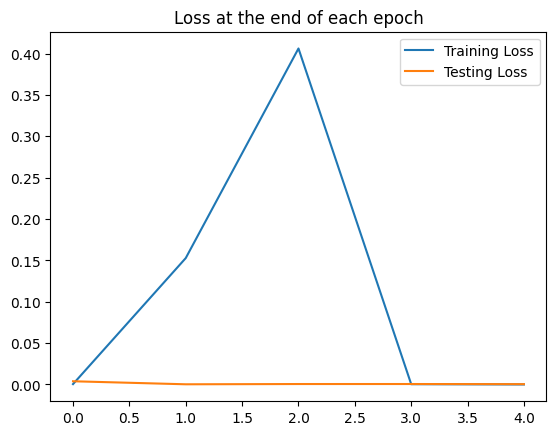

In [27]:
# Plot the loss in a chart

train_losses = [t.item() for t in train_losses]
test_losses = [t.item() for t in test_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the end of each epoch')
plt.legend()

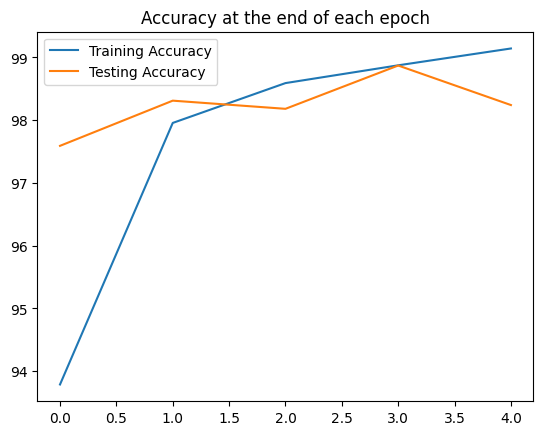

In [31]:
# Plot the accuracy at the end of each epoch

plt.plot([t.item()/600 for t in train_correct], label='Training Accuracy')
plt.plot([t.item()/100 for t in test_correct], label='Testing Accuracy')
plt.plot
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [33]:
# Loading the whole test dataset

data_loader_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [42]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in data_loader_all:
    labels_pred = model(X_test)
    predicted = torch.max(labels_pred.data, 1)[1]
    correct += (predicted == y_test).sum()

In [43]:
# % of correct

print(correct.item()/len(test_data)*100)

98.24000000000001


In [56]:
# Lets grab an image

test_data[4200] #tensor with an image in it.. at end it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [57]:
# Lets grab just the data .. without the label at the end which is 9
test_data[4200][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [58]:
# Reshape it
test_data[4200][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

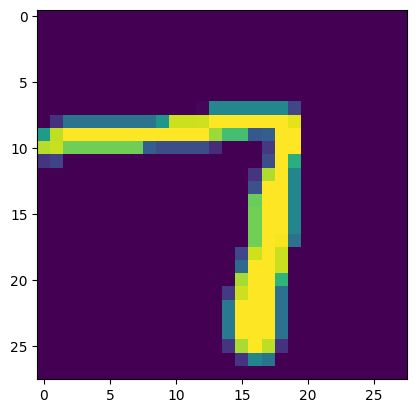

In [59]:
# Lets show the image
plt.imshow(test_data[4200][0].reshape(28,28))

In [60]:
# Pass the image through the model

model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4200][0].view(1,1,28,28)) #batch size = 1 , color channel =1 , 28x28 image

In [61]:
# Check the new Prediction and check the probabilities

new_prediction

tensor([[-2.8173e+01, -1.7479e+01, -1.7764e+01, -1.0114e+01, -2.0619e+01,
         -2.0128e+01, -3.8967e+01, -4.0769e-05, -2.4561e+01, -1.5085e+01]])

In [62]:
new_prediction.argmax()

tensor(7)